In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import random
import numpy as np
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

seed = 2023
deterministic = True

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

cuda:0


In [ ]:
#car hacking dataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler


def makediff(df):
    res = df.copy()
    res['diff'] = df.groupby('id')['Timestamp'].diff()
    res['diff'].fillna(res.groupby('id')['diff'].transform('mean'), inplace=True)
    res['diff'] *= 80
    res['diff'] = np.log2(res['diff'])
    return res


def makeset(path):
    df = pd.read_csv(path)
    df = df.iloc[:, [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11]]
    df.columns = ['Timestamp', 'id', 'd0', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'label']
    df = df.dropna()
    df = makediff(df)
    df.iloc[:, 1:10] = df.iloc[:, 1:10].apply(lambda x: x.astype(str).map(lambda x: int(x, 16)))
    # df = df[['id', 'diff', 'diff2', 'label']]
    df = df[['id', 'diff', 'label']]
    df['id'] /= 256
    return np.array(df)


dosData = makeset('/content/drive/MyDrive/ADD/CAR/DoS_dataset.csv')
fuzzyData = makeset('/content/drive/MyDrive/ADD/CAR/Fuzzy_dataset.csv')
rpmData = makeset('/content/drive/MyDrive/ADD/CAR/RPM_dataset.csv')
gearData = makeset('/content/drive/MyDrive/ADD/CAR/gear_dataset.csv')


# f = open('/content/drive/MyDrive/ADD/CAR/normal_run_data.txt', 'r')
# lines = f.readlines()
# time = list()
# id_list = list()
# payload = list()
# interval = list()
# for line in lines:
#     line.strip()
#     line = line.split()
#     if len(line) <= 3: continue
#     time.append(line[1])
#     id_list.append(line[3])
#     temp = line[7:]
#     while len(temp) < 8:
#         temp.append('00')
#     payload.append(temp)


# df0 = pd.DataFrame(time, columns=['Timestamp'])
# df1 = pd.DataFrame(id_list, columns=['id'])
# df2 = pd.DataFrame(payload, columns=['d0', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7'])
# df = pd.concat([df0, df1, df2], axis=1)
# df['Timestamp'] = df['Timestamp'].astype('float')
# df = makediff(df)
# df['Label'] = 'R'
# df.to_csv('/content/drive/MyDrive/ADD/CAR/normal_dataset.csv', index=False)

df = pd.read_csv('/content/drive/MyDrive/ADD/CAR/normal_dataset.csv')
df.iloc[:, 1:10] = df.iloc[:, 1:10].apply(lambda x: x.astype(str).map(lambda x: int(x, 16)))
df['id'] /= 256
df = df[['id', 'diff']]
free = np.array(df)

<ipython-input-4-0d6d4d0d957a>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:, 1:10] = df.iloc[:, 1:10].apply(lambda x: x.astype(str).map(lambda x: int(x, 16)))
<ipython-input-4-0d6d4d0d957a>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:, 1:10] = df.iloc[:, 1:10].apply(lambda x: x.astype(str).map(lambda x: int(x, 16)))
<ipython-input-4-0d6d4d0d957a>:22: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old 

In [ ]:
import torch
from collections import defaultdict
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np


N = 200
d = 50


def makeDataset(data):
    X, Y = list(), list()
    XX, YY = list(), list()
    for i in range(0, len(data), d):
        if i + N < len(data):
            temp = data[i:i+N]
            flag = 1
            for t in temp:
                if t[-1] == 'T':
                    a = np.array(temp[:, :-1]).astype(np.float32)
                    XX.append(torch.tensor(a, dtype=torch.float32))
                    YY.append(t[-1])
                    flag = 0
                    break
            if flag:
                a = np.array(temp[:, :-1]).astype(np.float32)
                X.append(torch.tensor(a, dtype=torch.float32))
                Y.append(t[-1])
    return X, Y, XX, YY


class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        return self.x[index], self.y[index]


trainX, trainY, _, _ = makeDataset(free)
dataset = CustomDataset(trainX, trainY)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear, Conv1d, LSTM


class customModel(nn.Module):
    def __init__(self, in_channels, channels):
        super(customModel, self).__init__()
        self.conv1d = Conv1d(in_channels, channels, kernel_size=3, padding=1)
        self.rnn = LSTM(channels, channels, num_layers=2, bidirectional=True, batch_first=True)
        self.fc = Linear(channels*2, 2)

    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.conv1d(x).relu()
        x = x.transpose(1, 2)
        x, state = self.rnn(x)
        x = x.relu()
        x = self.fc(x)
        return x

In [ ]:
def Training(model, tr):
    epochs = 100
    criterion = torch.nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    model.train()
    for epoch in range(epochs):
        for i, d in enumerate(tr):
            optimizer.zero_grad()
            x = d[0].to(device)
            out = model(x)
            loss = criterion(out, x)
            loss.backward()
            optimizer.step()
            if i%100 == 0:
                print(f'epoch: {epoch} [{100*i/len(tr):.4f}%] loss: {loss.item():.6f}')


trainLoader = DataLoader(dataset, batch_size=32, shuffle=True)
model = customModel(2, 128)
model.to(device)
Training(model, trainLoader)

In [ ]:
norX1, norY1, attX1, attY1 = makeDataset(fuzzyData)

normaldataset1 = CustomDataset(norX1, norY1)
attackdataset1 = CustomDataset(attX1, attY1)

norX2, norY2, attX2, attY2 = makeDataset(gearData)

normaldataset2 = CustomDataset(norX2, norY2)
attackdataset2 = CustomDataset(attX2, attY2)

norX3, norY3, attX3, attY3 = makeDataset(rpmData)

normaldataset3 = CustomDataset(norX3, norY3)
attackdataset3 = CustomDataset(attX3, attY3)

norX4, norY4, attX4, attY4 = makeDataset(dosData)

normaldataset4 = CustomDataset(norX4, norY4)
attackdataset4 = CustomDataset(attX4, attY4)

In [ ]:
import matplotlib.pyplot as plt


def test(model, ts):
    res = list()
    criterion = torch.nn.L1Loss()
    model.eval()
    with torch.no_grad():
        for i, d in enumerate(ts):
            x = d[0].to(device)
            out = model(x)
            res.append(criterion(out, x).item())
    return res


ft1 = DataLoader(normaldataset1, batch_size=1, shuffle=False)
at1 = DataLoader(attackdataset1, batch_size=1, shuffle=False)
f1 = test(model, ft1)
a1 = test(model, at1)

ft2 = DataLoader(normaldataset2, batch_size=1, shuffle=False)
at2 = DataLoader(attackdataset2, batch_size=1, shuffle=False)
f2 = test(model, ft2)
a2 = test(model, at2)

ft3 = DataLoader(normaldataset3, batch_size=1, shuffle=False)
at3 = DataLoader(attackdataset3, batch_size=1, shuffle=False)
f3 = test(model, ft3)
a3 = test(model, at3)

ft4 = DataLoader(normaldataset4, batch_size=1, shuffle=False)
at4 = DataLoader(attackdataset4, batch_size=1, shuffle=False)
f4 = test(model, ft4)
a4 = test(model, at4)

free, 0.760916
attack, 0.753998
free2, 0.159812
attack2, 1.297155
free3, 0.196094
attack3, 1.172422
free4, 0.999760
attack4, 0.264597


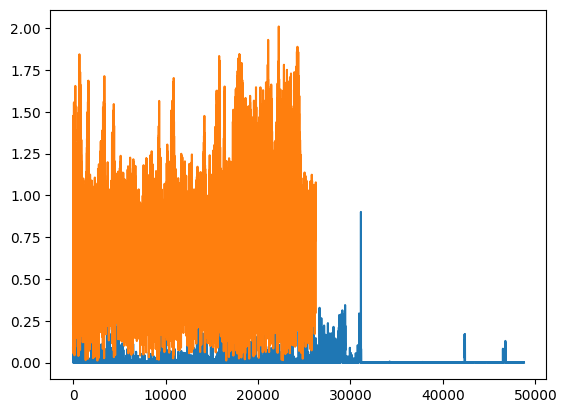

In [ ]:
plt.plot(f1, label='free1')
plt.plot(a1, label='attack1')

plt.plot(f2, label='free2')
plt.plot(a2, label='attack2')

plt.plot(f3, label='free3')
plt.plot(a3, label='attack3')

plt.plot(f4, label='free4')
plt.plot(a4, label='attack4')

plt.legend()
plt.show()